# Max-Cut for Quantum Network Defense (QDN)


### Program made by Evan Spillane
### Capping functionality edits made by JP Booth
Last updated: 12/4/2023 1:25 AM

##### with Contributions from Harrison Zheng and Alex Badia

In [1]:

# Qiskit Runtime & Primitive Imports
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit_ibm_runtime import (Session, Options, QiskitRuntimeService,
                                Sampler as RuntimeSampler,
                                Estimator as RuntimeEstimator)

# Noise Model & Fake backend imports
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit_aer.noise import NoiseModel

# VQE Imports
from qiskit.algorithms.minimum_eigensolvers import VQE, SamplingVQE, VQEResult
from qiskit.algorithms.optimizers import OptimizerResult

# Ansatz imports
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import QAOAAnsatz

# Maxcut and Custom Minimizer imports
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from scipy.optimize import minimize
from qiskit.algorithms.optimizers import SPSA


# Graphing and Diagram imports
import plotly.express as px
from qiskit import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from qiskit.visualization import plot_distribution

# Algorithm Optimizers
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM, SPSA, L_BFGS_B

# Callback functionality
import time
from copy import copy
from typing import List
from datetime import timedelta
from humanfriendly import format_timespan

# QUBO Imports
from qiskit.circuit import Parameter, ParameterVector
from qiskit_optimization import QuadraticProgram
from qiskit.quantum_info import Operator

# Creds
import cain

#Elist Generator
import DataConverter


from datetime import datetime

# Setting a variable to the current time using now()
current_time = datetime.now()
curTime = str(current_time.day) + "-" + str(current_time.month) + "-" + str(current_time.year) + "-" + str(current_time.hour) + "_" + str(current_time.minute)
dir = curTime + "_Results"

#choose a file location for the results with \ at end, sub folders will be made in the directory
fileLoc = input("Choose results file location (\ at end)")
dir = fileLoc + dir
import os
os.mkdir(dir) 

C:\Users\clone\AppData\Local\Temp\ipykernel_756\3437911212.py:12: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE, SamplingVQE, VQEResult


In [2]:
accType = input("Please select account type (type q for ibm_quantum and c for ibm_cloud)")

if accType == "q":
    chan = "ibm_quantum"
    name = "q"
    token = "7692c263cefff7b8692e781b35975e1e6d0ea2fc00779f25f2a395d25425d89a38f5b521ffdd5d0d9b74adcd1bfa5e00042125c8cbe0785e05df188cd1d7c76c"
    instance = "ibm-q/open/main"
elif accType == "c":
    chan = cain.cchan
    name = cain.cname
    token = cain.ctoken
    instance = cain.cinstance
    
service = QiskitRuntimeService(channel=chan, token=token, instance=instance)

""" Desired instance goes here,
    For running jobs on the quantum machine, use "ibmq_guadalupe"
    For running jobs on a simulator, use "simulator_statevector" or "ibmq_qasm_simulator"

Current End-Of-Life for backends is ~September 26, 2023
    backend = "simulator_statevector"
    backend = "ibmq_qasm_simulator"
    backend = "ibmq_guadalupe" 
    backend = "ibmq_jakarta"
"""

# Now takes user input to specify backend
backendChoice = input(
    "Which backend would you like to use? (please type 'sim' or 'real')")

if backendChoice == ("sim"):
    noiseChoice = input("Run a noisy simulation? (y / n)")
    backend = "ibmq_qasm_simulator"
    # backend = "simulator_statevector"
    if noiseChoice == "y":
        backend = "ibmq_qasm_simulator"
        nOptimizer = "SPSA"
    else:
        backend = "simulator_statevector"
        from qiskit.primitives import Estimator
        from qiskit.primitives import Sampler
    
elif backendChoice == ("real"):
    realChoice = input("Which real backend would you like to use? Enter the name of the machine (ex. 'guadalupe')")
    if realChoice == "guadalupe":
        backend = "ibmq_guadalupe"
    else:
        print("please enter a valid real backend")
else:
    print("Please respond with a valid choice, print either sim or real with no extra characters")
    
# DO NOT PRINT print("Saved Accounts: " + str(service.saved_accounts()))
# DNP print("Current Account: " + str(service.active_account()))

print("Available Backends: ")
print(*service.backends(), sep="\n")

AuthenticationLicenseError: 'License required. You need to accept the License.'

## Attack set key (input the letter/number combonation ONLY)

| Set # | Nodes | Description | Graph |
| ---: | -----: | :---------------------------------- | ----------------------------- |
| B0 | 7 | A set used for benchmarking basic accuracy |
| B1 | 7 | A second set used for benchmarking basic accuracy |
| R1 | 12 | Reg set 2; Attack weights are 1.15 |
| R2 | 12 | Red set 2.2 Same set as 12 BUT attack weights are 5 |
| R3 | 14 | Reg Set 1 |
| L1 | 49 | Largest set that can run on a simulator (has 50qubits max) |
| L5 | 126 | The largest attack set. Cannot be run or checked classically |


In [ ]:
# Prepared Parameters
""" ## Parameters for Tests
==============================
- Data set: (1, 2, 3, 4, 5)
- Number of nodes: n
- Reps(Circuit Depth)
    - for QAOA: reps = repsQAOA
    - for VQE: reps = repsVQE
- Optimizer (for QAOA): _(ADAM | COBYLA | SPSA | SLSQP)_
- Ansatz (for VQE): _(EfficientSU2 | TwoLocal)_   """

print("Test is set to run on : " + backend)

print("Parameters for next test")
print("================")

# Prompt for set selection
attackSet = input("Which attack set would you like to run?")
if backendChoice == "sim":
    sTitle = " (Set: " + attackSet + ")"
    if attackSet == ("B0"):
        sset = 0
        n = 7
    elif attackSet == ("B1"):
        sset = 1
        n = 7
    elif attackSet == ("R1"):
        sset = 2
        n = 12
    elif attackSet == ("R2"):
        sset = 3
        n = 12
    elif attackSet == ("R3"):
        sset = 4
        n = 14
    elif attackSet == ("P1"):
        sset = 6
        n = 10
    elif attackSet == ("P2"):
        sset = 7
        n = 13
    elif attackSet == ("P3"):
        sset = 8
        n = 9
    elif attackSet == ("P4"):
        sset = 9
        n = 10
    elif attackSet == ("P5"):
        sset = 10
        n = 10
    elif attackSet == ("P6"):
        sset = 11
        n = 10
    elif attackSet == ("custom"):
        filePath = input("Input File Path to CSV")
        customList = DataConverter.extract_random_entries(filePath, 10, 5)
        sset = 12
        n = 16 #number of nodes (honeypot + 15 sources)
    else:
        print("Please respond with a valid choice, print the number with no extra spaces (REMINDER: SIMULATORS CAN NOT RUN SETS WITH MORE THAN ~20 NODES)")

if backendChoice == "real":
    sTitle = "Set: " + attackSet
    nOptimizer = "SPSA"
    if attackSet == ("B0"):
        sset = 0
        n = 7
    elif attackSet == ("B1"):
        sset = 1
        n = 7
    elif attackSet == ("R1"):
        sset = 2
        n = 12
    elif attackSet == ("R2"):
        sset = 3
        n = 12
    elif attackSet == ("R3"):
        sset = 4
        n = 14
    elif attackSet == ("F1"):
        sset = 5
        n = 45
    elif attackSet == ("L1"):
        sset = 6
        n = 49
    elif attackSet == ("L5"):
        sset = 7
        n = 126
    elif attackSet == ("P1"):
        sset = 6
        n = 10
    elif attackSet == ("P2"):
        sset = 7
        n = 13
    elif attackSet == ("P3"):
        sset = 8
        n = 9
    elif attackSet == ("P4"):
        sset = 9
        n = 10
    elif attackSet == ("P5"):
        sset = 10
        n = 10
    elif attackSet == ("P6"):
        sset = 11
        n = 10
    else:
        print("Please respond with a valid choice, print the number with no extra spaces")

print("Selected Set : " + attackSet)

Test is set to run on : simulator_statevector
Parameters for next test


['Attack', '958', '194', '60.30373096', '46.34.161.241:21231', 'Iran']
['Attack', '904', '33', '11.94749668', '138.68.165.12:80', 'United Kingdom']
['Attack', '477', '218', '68.8345947', '196.200.173.83:80', 'Morocco']
['Attack', '371', '269', '64.49684815', '109.75.252.74:8080', 'Russian Federation']
['Attack', '32', '164', '68.55953549', '88.255.102.20:23500', 'Turkey']
['Attack', '654', '106', '110.2031457', '5.39.48.34:80', 'France']
['Attack', '623', '251', '58.58525115', '205.202.34.197:8080', 'United States']
['Attack', '214', '179', '46.14132985', '91.223.12.207:80', 'Italy']
['Attack', '482', '158', '45.27926198', '177.11.113.151:8080', 'Brazil']
['Attack', '297', '54', '15.94026848', '212.33.202.126:80', 'Iran']
['Not Attack', '1389', '2', '14.28357345', '191.101.21.226:3128', 'Netherlands']
['Not Attack', '1311', '4', '11.68627748', '96.11.142.22:8080', 'United States']
['Not Attack', '1670', '7', '25.04139931', '159.203.152.83:3128', 'United States']
['Not Attack', '1374', 

## Setting up Fake Noise Model & Backend

In [ ]:
import qiskit_aer

# Make a noise model
fake_backend = FakeGuadalupe()
noise_model = NoiseModel.from_backend(fake_backend)


# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 10000
options.optimization_level = 0
options.resilience_level = 1


# Set options to include the noise model with error mitigation
options_with_em = Options()
options_with_em.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_with_em.execution.shots = 10000
options_with_em.optimization_level = 0  # no optimization
options_with_em.resilience_level = 1  # M3 for Sampler and T-REx for Estimator


# PEC Setup

You can ignore this as it is entering predetermined data sets

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime

G = nx.Graph()  # Graph G is the Brute Force Graph
G2 = nx.Graph()  # Graph G2 is the QAOA Solution Graph
G3 = nx.Graph()  # Graph G3 is the VQE Solution Graph
G4 = nx.Graph()  # Graph G4 is the EigenOptimizer Check Solution Graph

G.add_nodes_from(np.arange(0, n, 1))
G2.add_nodes_from(np.arange(0, n, 1))
G3.add_nodes_from(np.arange(0, n, 1))
G4.add_nodes_from(np.arange(0, n, 1))

"""List is formatted as the following
    (x, y, z)
        x = # of the node (it's identifier)
        y = The node that x is connected to
        z = Weight of the line between x and y """


# Baseline Set B0
elist0 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 1),
    (0, 6, 1),
    (1, 0, 1),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 1),
    (1, 6, 1),
    (5, 6, 1)
]

# Baseline Set B1
elist1 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 1),
    (0, 6, 1),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 1),
    (1, 6, 1),
    (5, 6, 1)
]

# Attack Set R1
elist2 = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 3, 1.0),
    (0, 4, 1.15),
    (0, 5, 1.15),
    (0, 6, 1.15),
    (0, 7, 1.0),
    (0, 8, 1.15),
    (0, 9, 1.15),
    (0, 10, 1.15),
    (0, 11, 1.0),
    (1, 0, 1.15),
    (1, 4, 1.15),
    (1, 5, 1.15),
    (1, 6, 1.15),
    (1, 8, 1.15),
    (1, 9, 1.15),
    (1, 10, 1.15),
    (2, 7, 1.0),
    (3, 11, 1.0)
                    ]

# Attack Set R2
elist3 = [
    (0, 1, 1),
    (0, 2, 1),
    (0, 3, 1),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 1),
    (0, 8, 5),
    (0, 9, 5),
    (0, 10, 5),
    (0, 11, 1),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (1, 8, 5),
    (1, 9, 5),
    (1, 10, 5),
    (2, 7, 1),
    (3, 11, 1)]

# Attack Set R3
elist4 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 1),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 5),
    (0, 8, 5),
    (0, 9, 5),
    (0, 10, 5),
    (0, 11, 5),
    (0, 12, 5),
    (0, 13, 5),
    (1, 3, 1),
    (2, 4, 5),
    (2, 5, 5),
    (2, 6, 5),
    (2, 7, 5),
    (2, 8, 5),
    (2, 9, 5),
    (2, 10, 5),
    (2, 11, 5),
    (2, 12, 5),
    (2, 13, 5)]

# Attack Set F1 (45 nodes)
elist5 = [
    (0, 1, 1),
    (0, 2, 1),
    (0, 3, 1),
    (0, 4, 1),
    (0, 5, 1),
    (0, 6, 1),
    (0, 7, 1),
    (0, 8, 1),
    (0, 9, 1),
    (0, 10, 5),
    (0, 11, 5),
    (0, 12, 5),
    (0, 13, 5),
    (0, 14, 5),
    (0, 15, 5),
    (0, 16, 5),
    (0, 17, 5),
    (0, 18, 5),
    (0, 19, 5),
    (0, 20, 5),
    (0, 21, 5),
    (0, 22, 5),
    (0, 23, 5),
    (0, 24, 5),
    (0, 25, 5),
    (0, 26, 5),
    (0, 27, 5),
    (0, 28, 5),
    (0, 29, 5),
    (0, 30, 5),
    (0, 31, 5),
    (0, 32, 5),
    (0, 33, 5),
    (0, 34, 5),
    (0, 35, 5),
    (0, 36, 5),
    (0, 37, 5),
    (0, 38, 5),
    (0, 39, 5),
    (0, 40, 5),
    (0, 41, 5),
    (0, 42, 5),
    (0, 43, 5),
    (1, 2, 1),
    (1, 3, 1),
    (1, 4, 1),
    (1, 5, 1),
    (1, 6, 1),
    (1, 7, 1),
    (1, 8, 1),
    (1, 9, 1),
    (1, 10, 5),
    (1, 11, 5),
    (1, 12, 5),
    (1, 13, 5),
    (1, 14, 5),
    (1, 15, 5),
    (1, 16, 5),
    (1, 17, 5),
    (1, 18, 5),
    (1, 19, 5),
    (1, 20, 5),
    (1, 21, 5),
    (1, 22, 5),
    (1, 23, 5),
    (1, 24, 5),
    (1, 25, 5),
    (1, 26, 5),
    (1, 27, 5),
    (1, 28, 5),
    (1, 29, 5),
    (1, 30, 5),
    (1, 31, 5),
    (1, 32, 5),
    (1, 33, 5),
    (1, 34, 5),
    (1, 35, 5),
    (1, 36, 5),
    (1, 37, 5),
    (1, 38, 5),
    (1, 39, 5),
    (1, 40, 5),
    (1, 41, 5),
    (1, 42, 5),
    (1, 43, 5),
    (1, 44, 5),
    (2, 3, 1),
    (2, 5, 1),
    (3, 7, 1),
    (4, 5, 1),
    (7, 9, 1)
        ]


# Elist P1 (Set 1 from Paper)
elist6 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (1, 7, 5),
    (8, 0, 1),
    (9, 1, 1)]


# Elist P2 (Set 2 from Paper)
elist7 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 5),
    (0, 8, 5),
    (0, 9, 5),
    (0, 10, 5),
    (0, 11, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (1, 7, 5),
    (1, 8, 5),
    (1, 9, 5),
    (1, 10, 5),
    (1, 11, 5),
    (12, 0, 1)]


# Elist P3 (Set 3 from Paper)
elist8 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (5, 0, 1),
    (6, 0, 1),
    (7, 1, 1),
    (8, 1, 1)]


# Elist P4 (Set 4 from Paper)
elist9 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (7, 0, 1),
    (8, 0, 1),
    (9, 1, 1)]


# Elist P5 (Set 5 from Paper)
elist10 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (0, 7, 5),
    (8, 0, 1),
    (9, 1, 1)]


# Elist P6 (Set 6 from Paper)
elist11 = [
    (0, 1, 1),
    (0, 2, 5),
    (0, 3, 5),
    (0, 4, 5),
    (0, 5, 5),
    (0, 6, 5),
    (0, 7, 5),
    (1, 2, 5),
    (1, 3, 5),
    (1, 4, 5),
    (1, 5, 5),
    (1, 6, 5),
    (0, 7, 5),
    (8, 0, 1),
    (9, 1, 1)]


In [ ]:
setList = [elist0, elist1, elist2,
           elist3, elist4, elist5,
           elist6, elist7, elist8, elist9, elist10, elist11, customList]

elist = setList[sset]

#adding elist to results file
toWrite = "Elist used: "
i=0
while (i < len(elist)):
    toWrite += str(elist[i])
    i+=1
print(toWrite)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)
G2.add_weighted_edges_from(elist)
G3.add_weighted_edges_from(elist)
G4.add_weighted_edges_from(elist)


colors = ['r' for node in G.nodes()]
colors2 = ['r' for node in G2.nodes()]
colors3 = ['r' for node in G3.nodes()]
colors4 = ['r' for node in G4.nodes()]


pos = nx.spring_layout(G)
pos2 = nx.spring_layout(G2)
pos3 = nx.spring_layout(G3)
pos4 = nx.spring_layout(G4)


style2 = ['solid' for edge in G2.edges()]
style3 = ['solid' for edge in G3.edges()]
style4 = ['solid' for edge in G4.edges()]

# Condiser having the title as an argument of the draw_graph call
# This would allow any of the draw_graphs to be used and still have the correct title

def draw_graph(G, colors, pos, title):
    default_axes = plt.axes(frameon=True)
    # Titles Graph
    plot_title = title

    # Label variable for X-axis
    xax = ""

    # Label variable for Y-axis
    yax = ""

    # Calls to title
    plt.title(plot_title)
    plt.xlabel(xax)
    plt.ylabel(yax)

    # Main drawing call of the graph
    
    # style = nx.get_edge_attributes(G, 'style')
    nx.draw_networkx_edges(G, pos=pos)
    # nx.draw_networkx_edges(G, pos=pos, style=style)
    # nx.draw_networkx_edges(G, pos=pos, style='dashed')
    nx.draw_networkx(G, node_color=colors, node_size=600,
                     alpha=.8, ax=default_axes, pos=pos)
    # nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    # edge_color : color or array of colors (default='k')
    # Find a way to make cut lines into dotted lines

    # Create 2 edgelists. 1 with the non-cut edges, and another with only the cut edges

    # cut_edges = [(u, v) for u, v in G.edges if lut[u] != lut[v]]
    # uncut_edges = [(u, v) for u, v in G.edges if lut[u] == lut[v]]

    # nx.draw_networkx_edges(G, pos, edgelist=cut_edges,
    #                       style='dashdot', alpha=0.5, width=3)
    # nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)


def draw_graph2(G2, colors2, pos2, title2):
    default_axes = plt.axes(frameon=True)
    # Titles Graph
    plot_title = title2

    # Label variable for X-axis
    xax = ""

    # Label variable for Y-axis
    yax = ""

    # Calls to title
    plt.title(plot_title)
    plt.xlabel(xax)
    plt.ylabel(yax)

    # Main drawing call of the graph
    
    # style2 = nx.get_edge_attributes(G2, 'style')
    nx.draw_networkx_edges(G2, pos=pos2)
    # nx.draw_networkx_edges(G2, pos=pos2, style=style2)
    nx.draw_networkx(G2, node_color=colors2, node_size=600,
                     alpha=.8, ax=default_axes, pos=pos2)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos=pos2, edge_labels=edge_labels)

# Draw third graph
def draw_graph3(G3, colors3, pos3, title3):
    default_axes = plt.axes(frameon=True)
    # Titles Graph
    plot_title = title3

    # Label variable for X-axis
    xax = ""

    # Label variable for Y-axis
    yax = ""

    # Calls to title
    plt.title(plot_title)
    plt.xlabel(xax)
    plt.ylabel(yax)

    # Main drawing call of the graph
    
    # style3 = nx.get_edge_attributes(G3, 'style')
    nx.draw_networkx_edges(G3, pos=pos3)
    # nx.draw_networkx_edges(G3, pos=pos3, style=style3)
    nx.draw_networkx(G3, node_color=colors3, node_size=600,
                     alpha=.8, ax=default_axes, pos=pos3)
    edge_labels = nx.get_edge_attributes(G3, 'weight')
    nx.draw_networkx_edge_labels(G3, pos=pos3, edge_labels=edge_labels)

Elist used: (1, 0, 5)(2, 0, 5)(3, 0, 5)(4, 0, 5)(5, 0, 5)(6, 0, 5)(7, 0, 5)(8, 0, 5)(9, 0, 5)(10, 0, 5)(11, 0, 1)(12, 0, 1)(13, 0, 1)(14, 0, 1)(15, 0, 1)


Weight Matrix:  [[0. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 1. 1. 1. 1. 1.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
case = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 55.0
case = [0, 1, 0, 0, 0, 0, 0, 0, 

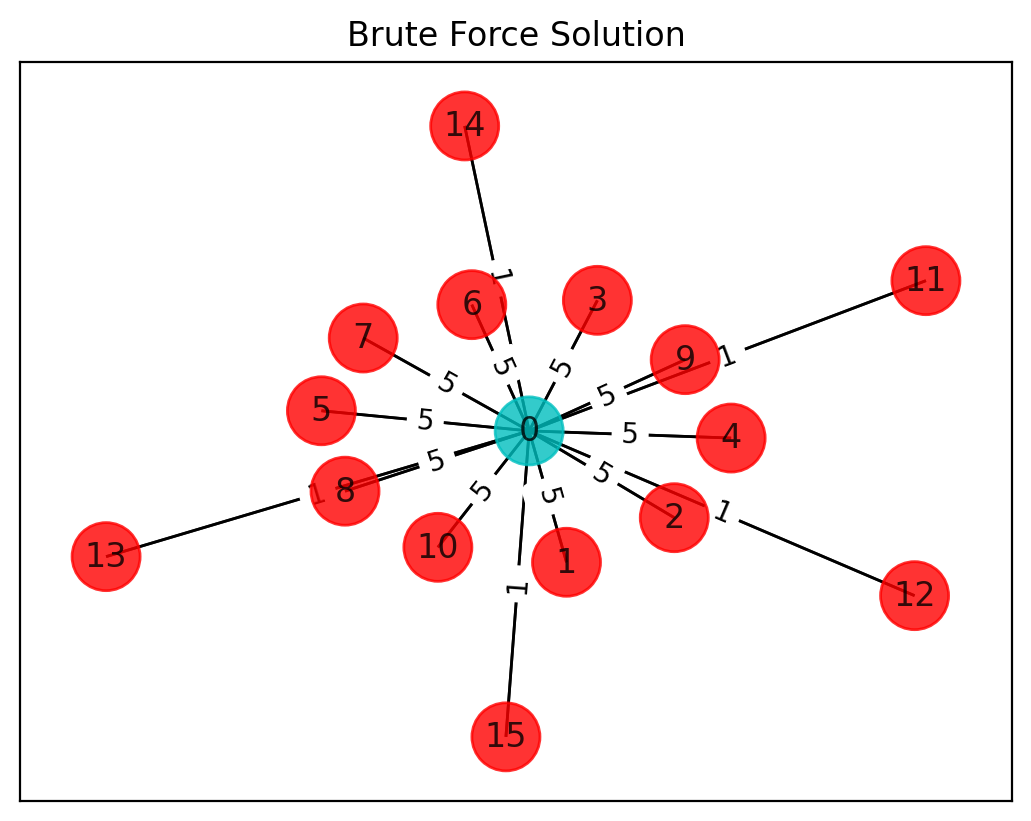

In [ ]:
#curTime = current_time.hour + ":" + current_time.minute + "_" + current_time.month + "/" + current_time.date + "/" + current_time.year
#nx.draw(draw_graph(G, colors, pos))

# Saves graph as file in directory with timestamp
#plt.savefig(dir + "BruteForce.png") 

# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp['weight']
print("Weight Matrix: ", w)


# n is the number of nodes
# If there are more than 20 nodes in an attack set, brute force will take the average computer a non-polynomial time to solve it. 
if n < 20: # This statement stops the program from attempting Brute Force if it won't be able to solve it
    best_cost_brute = 0
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j]*x[i]*(1-x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        print('case = ' + str(x) + ' cost = ' + str(cost))

    colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
    style = ['solid' if xbest_brute[i] == 0 else 'dashed' for i in range(n)]
    title = "Brute Force Solution"

    # Final draw of brute force graph
    draw_graph(G, colors, pos, title)
    print('\nBest solution = ' + str(xbest_brute) +
        ' cost = ' + str(best_cost_brute))
    print(style)
else:
    print("Brute Force Aborted, too many nodes! (Your set cannot be run through brute force)")

plt.savefig(dir + "/BestBruteForce.png") #Saves Brute force graph to results

In [ ]:

# Plotting functions
%config InlineBackend.figure_format = 'retina'

# Define our Qiskit Maxcut Instance
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()

# Translate to Ising Hamiltonian
qubitOp, offset = qp.to_ising()

print(qubitOp)


2.5 * IIIIIIIIIIIIIIZZ
+ 2.5 * IIIIIIIIIIIIIZIZ
+ 2.5 * IIIIIIIIIIIIZIIZ
+ 2.5 * IIIIIIIIIIIZIIIZ
+ 2.5 * IIIIIIIIIIZIIIIZ
+ 2.5 * IIIIIIIIIZIIIIIZ
+ 2.5 * IIIIIIIIZIIIIIIZ
+ 2.5 * IIIIIIIZIIIIIIIZ
+ 2.5 * IIIIIIZIIIIIIIIZ
+ 2.5 * IIIIIZIIIIIIIIIZ
+ 0.5 * IIIIZIIIIIIIIIIZ
+ 0.5 * IIIZIIIIIIIIIIIZ
+ 0.5 * IIZIIIIIIIIIIIIZ
+ 0.5 * IZIIIIIIIIIIIIIZ
+ 0.5 * ZIIIIIIIIIIIIIIZ


## Cost Function for Max Cut

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian,
                         parameter_values=params).result().values[0]
    return cost

In [ ]:
def get_cost_func(ansatz, hamiltonian, estimator):

    def eval_energy(params):
       energy = estimator.run(ansatz, hamiltonian,
                              parameter_values=params).result().values[0]
       return energy

    return eval_energy


## Callback Setup for both Algorithms

As it stands now, we are unable to save intermediate results from the iteration process, view the value of the cost function per iteration, nor are we able to monitor the progress of the routine. Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm. The standard SciPy callback routine allows for returning only the interim vector at each iteration. However, it is possible to do much more than this. Here we show how to use a mutable object, such as a dictionary, to store the current vector at each iteration, for example in case we need to restart the routine due to failure, and also return the current iteration number and average time per iteration.

In [ ]:

import time
from time import perf_counter

from humanfriendly import format_timespan


def buildCallback(ansatz, hamiltonian, estimator, callback_dict, maxiter, testAttempts):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(numFun, parameters, funVal, stepSize, accepted):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = funVal
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian,
                          parameter_values=parameters).result().values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - \
                callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] /
                  (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )

        if callback_dict["iters"] % maxiter != 0:
            curIter = callback_dict["iters"] % maxiter
        else:
            curIter = maxiter

        # Total number of iterations for all the specified tests
        totalIter = maxiter * testAttempts
        
        testNum = (callback_dict["iters"] // maxiter) + 1

        # Determines which test is currently in progress
        if testNum != testAttempts:
            curTest = testNum
        else:
            curTest = testAttempts


        # Finds total remaining iterations for all remaining tests
        remainingIters = totalIter - callback_dict["iters"]

        # Finds how many reps until a test is complete
        iterRem = maxiter - curIter
        
        testPercent = 100*(round(curIter/maxiter, 2))
        
        ovrPercent = 100*(round(callback_dict["iters"] / totalIter, 2))

        # Estimates remaining time based on average time per iteration
        if time_str != "-":
            total_testTime = round((float(time_str) * iterRem), 0)
            total_runTime = round(
                (float(time_str) * remainingIters), 0)
            testTimeRem = format_timespan(total_testTime)
            runtimeRem = format_timespan(total_runTime)
        else:
            testTimeRem = "-"
            runtimeRem = "-"
        # Print to screen on single line
        """print(
            "Test #: [{}] Iters. done: {} / {} [Avg. time per iter: {}] [Current Test Time Remaining: {}] [Total Est. Time Remaining {}]".format(
                curTest, curIter, maxiter, time_str, testTimeRem, runtimeRem),
            end="\r",
            flush=True,
        )
        
        # Print to screen on single line
        print(
            "Test #: [{}] Iters. done: {}/{} [Avg. time per iter: {}] [{}% Complete] [Total Est. Time Remaining {}]".format(
                curTest, curIter, maxiter, time_str, testPercent, runtimeRem),
            end="\r",
            flush=True,
        )"""
        
        # Print to screen on single line
        print(
            "Overall Test: [{}/{}] Iters. done: {}/{}  [Avg. time per iter: {}] [{}% Complete] [Total Est. Time Remaining {}]".format(
                curTest, testAttempts, curIter, maxiter, time_str, ovrPercent, runtimeRem),
            end="\r",
            flush=True,
        )

    return callback

#### Parameters for QAOA / VQE Shots and Circuit Depth

In [ ]:

# sets reps for QAOA function (Optimal Range: 1-2). 1 proved to be very efficient and accurate on set R2
qReps = 1

# sets reps for VQE ansatz (Optimal Range: 2-3). 3 isn't great at finding ideal solution, stick with 2 for now
vReps = 2

# Shots for QAOA sampler
qShots = 8192

# Shots for VQE sampler
vShots = 8192

# Max iterations for SPSA in QAOA (Range: 100-150)
maxiterQAOA = 150

# Max iterations for COBYLA in QAOA (Range: 25-35)
# maxiterQAOA = 30

# Max iterations for SPSA in VQE (Range: 250-350)
maxiterVQE = 300

# Max iterations for COBYLA in VQE (Range: 250-350)
# maxiterVQE = 300

# QAOA

### Prints the circuit in diagram form if desired

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

qAnsatz = QAOAAnsatz(qubitOp, reps=qReps)

circChoice = input("Would you like to print the circuit? ( y / n )")
if circChoice == "y":
    qAnsatz.decompose(reps=3).draw("mpl")
else:
    print("Circuit not printed")

#if n < 20:
    # Draw
    #qAnsatz.decompose(reps=3).draw("mpl")
#else:
    #print("Circuit can not be displayed, too many nodes!")

C:\Users\clone\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


In [ ]:
# User specifies how many times to run the test
testAttempsChoice = input("How many times should each algorithm be run?")
testAttempts = int(testAttempsChoice)

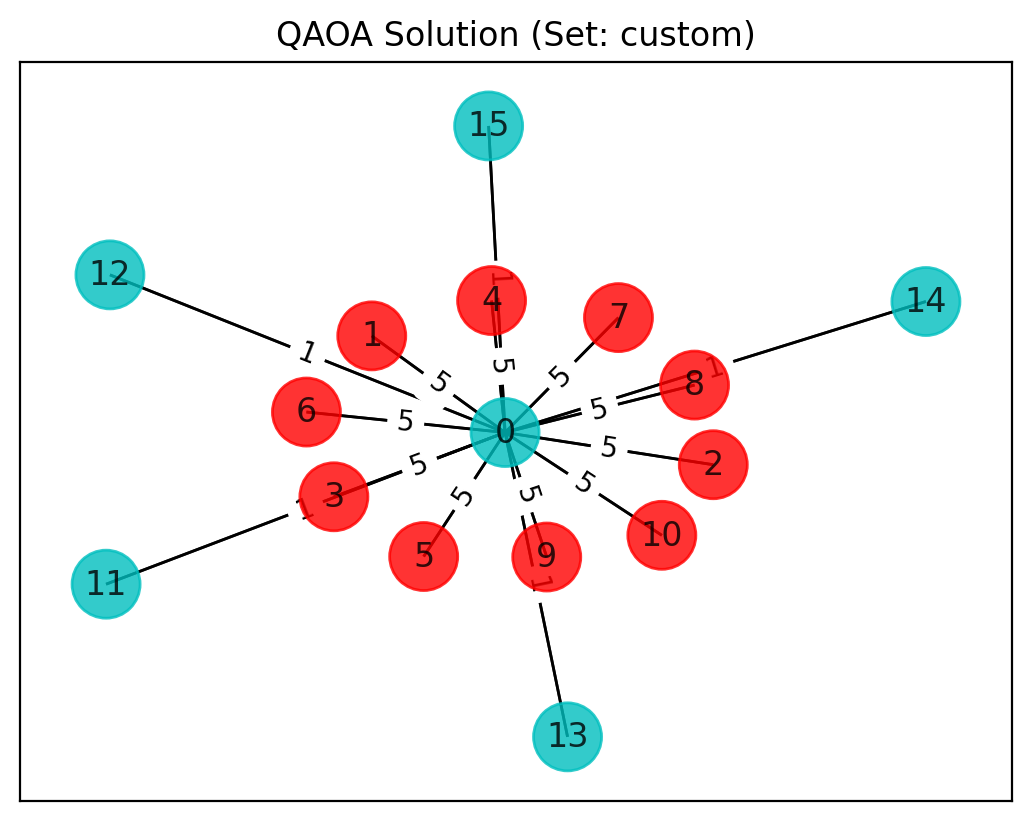

In [ ]:
# qAnsatz = QAOAAnsatz(qubitOp, reps=qReps)

QAOAResultArray = []

''' qRes is an OptimizerResult in the following format:
            Returns
                fun (float): The final value of the minimization.
                jac (POINT): The final gradient of the minimization.
                nfev (int): The total number of function evaluations.
                nit (int): The total number of iterations.
                njev (int): The total number of gradient evaluations.
                x (POINT): The final point of the minimization.
                '''

callback_dict_Q = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}

with Session(service=service, backend=backend) as session:
    estimator = Estimator(options={"shots": 8192,
                               "resilience_level": 2,
                               "optimization_level": 3
                               # "seed_simulator": 42
                               })
    sampler = Sampler(options={"shots": 8192,
                               "resilience_level": 1,
                               "optimization_level": 3
                               # "seed_simulator": 42
                               })
    
    callbackQ = buildCallback(ansatz=qAnsatz, hamiltonian=qubitOp, estimator=estimator, callback_dict=callback_dict_Q, maxiter=maxiterQAOA, testAttempts=testAttempts)
    optimizer = SPSA(maxiter=maxiterQAOA, callback=callbackQ)
    testNum = 1  # Counts which test the algorithm is currently on
    for i in range(testAttempts):
        # To begin the routine, we start by specifying a random initial set of parameters,
        x0q = 2 * np.pi * np.random.rand(qAnsatz.num_parameters)

        # Get the result of the minimizer
        qRes = optimizer.minimize(get_cost_func(
            qAnsatz, qubitOp, estimator), x0q)
        
        # Assign solution parameters to ansatz
        qqc = qAnsatz.assign_parameters(qRes.x)

        # Add measurements to our circuit
        qqc.measure_all()

        # Sample ansatz at optimal parameters
        samp_distQ = sampler.run(qqc, shots=int(1e4)).result().quasi_dists[0]
        xQAOA = max_cut.sample_most_likely(samp_distQ)

        QAOAResultArray.append(str(xQAOA))

    # Close the session since we are now done with it
    session.close()

xQAOA = max_cut.sample_most_likely(samp_distQ)

avgItersQ = callback_dict_Q["iters"] / testAttempts

#print('\nAll Solutions: ')
#for x in QAOAResultArray:
    #print(x)

# plot results
colors2 = ['r' if xQAOA[i] == 0 else 'c' for i in range(n)]
title2 = 'QAOA Solution' + sTitle
style2 = ['solid' if xQAOA[i] == 0 else 'dashed' for i in range(n)]
draw_graph2(G2, colors2, pos2, title2)

plt.savefig(dir + "/BestQAOA.png") #saves QAOA graph to results

In [ ]:
from collections import Counter

freqListQKey = list(Counter(QAOAResultArray).keys()) # equals to list(set(words))
freqListQ = list(Counter(QAOAResultArray).values()) # counts the elements' frequency

avgTimePerTest = callback_dict_Q["_total_time"] / testAttempts
avgItersQ = callback_dict_Q["iters"] / testAttempts

# print("Results Summary")
# print("\n ===========================")

#adds QAOA occurenses to results file
f = open(dir + "/Results.txt", 'w+')
toWrite += "\n\nQAOA Results:\n"
temp = 0
for k in freqListQKey:
  print('Occurences of ', k ,': ', freqListQ[temp])
  toWrite += 'Occurences of ' + str(k)  + ': ' + str(freqListQ[temp])
  temp += 1


# print("\nTotal Iterations: ", callback_dict_Q["iters"])
print("\nTotal Time: ", callback_dict_Q["_total_time"])
print("\nAverage Est. Time per test: ", str(round(avgTimePerTest, 2)),' seconds')
# print('Average Iterations per test: ', avgItersQ)


Occurences of  [0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0] :  1
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] :  1
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] :  2
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1] :  1

Total Time:  182.9192762998864

Average Est. Time per test:  36.58  seconds


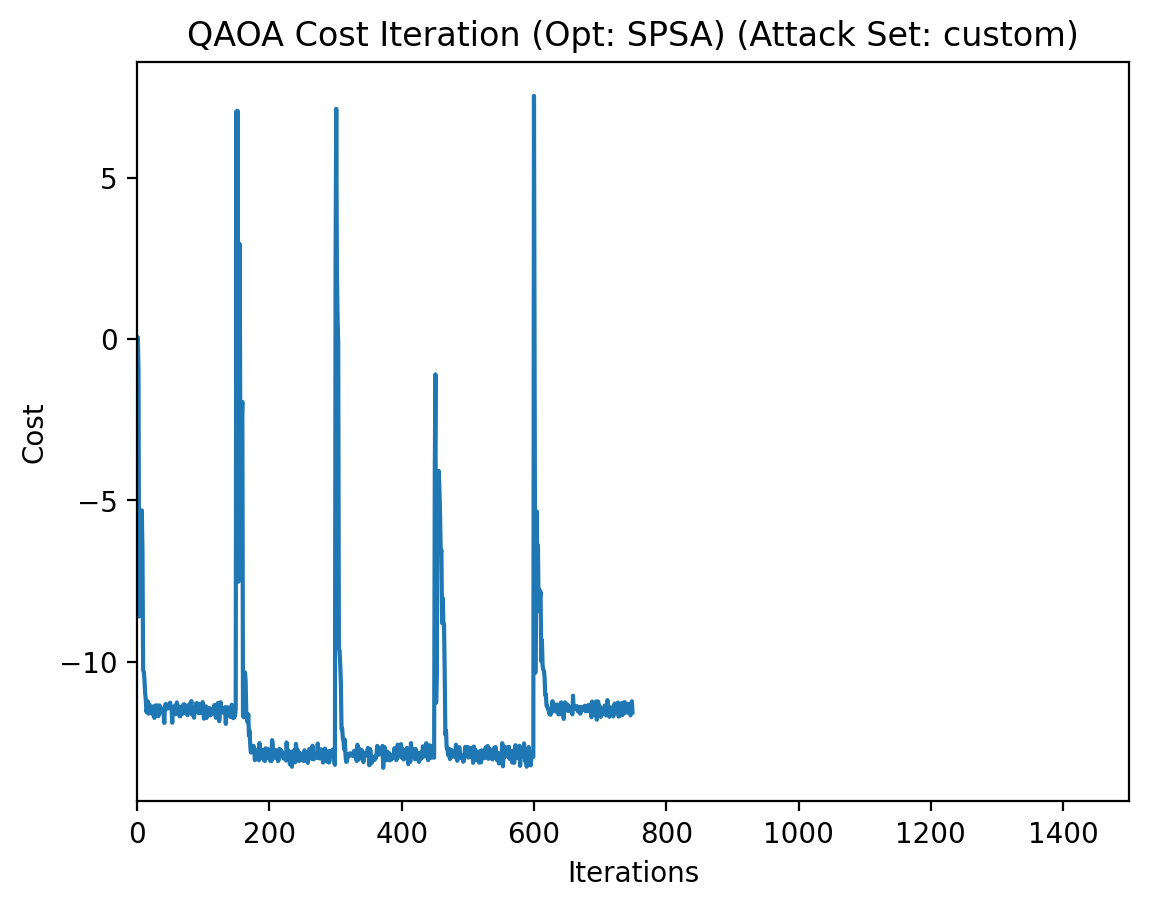

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_Q["iters"]), callback_dict_Q["cost_history"])
avgItersQ = callback_dict_Q["iters"] / testAttempts


qxlim = maxiterQAOA*10
ax.set_xlim([0, qxlim])
plot_title = 'QAOA Cost Iteration (Opt: SPSA) (Attack Set: ' + str(attackSet) + ')'
# plot_title = 'QAOA Cost Iteration (Opt: SPSA) (qReps: ' + str(qReps) + ') (Attack Set: ' + str(attackSet) + ')'

plt.title(plot_title)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

fig.savefig(dir + "/QAOACost") #saves QAOA cost graph to results

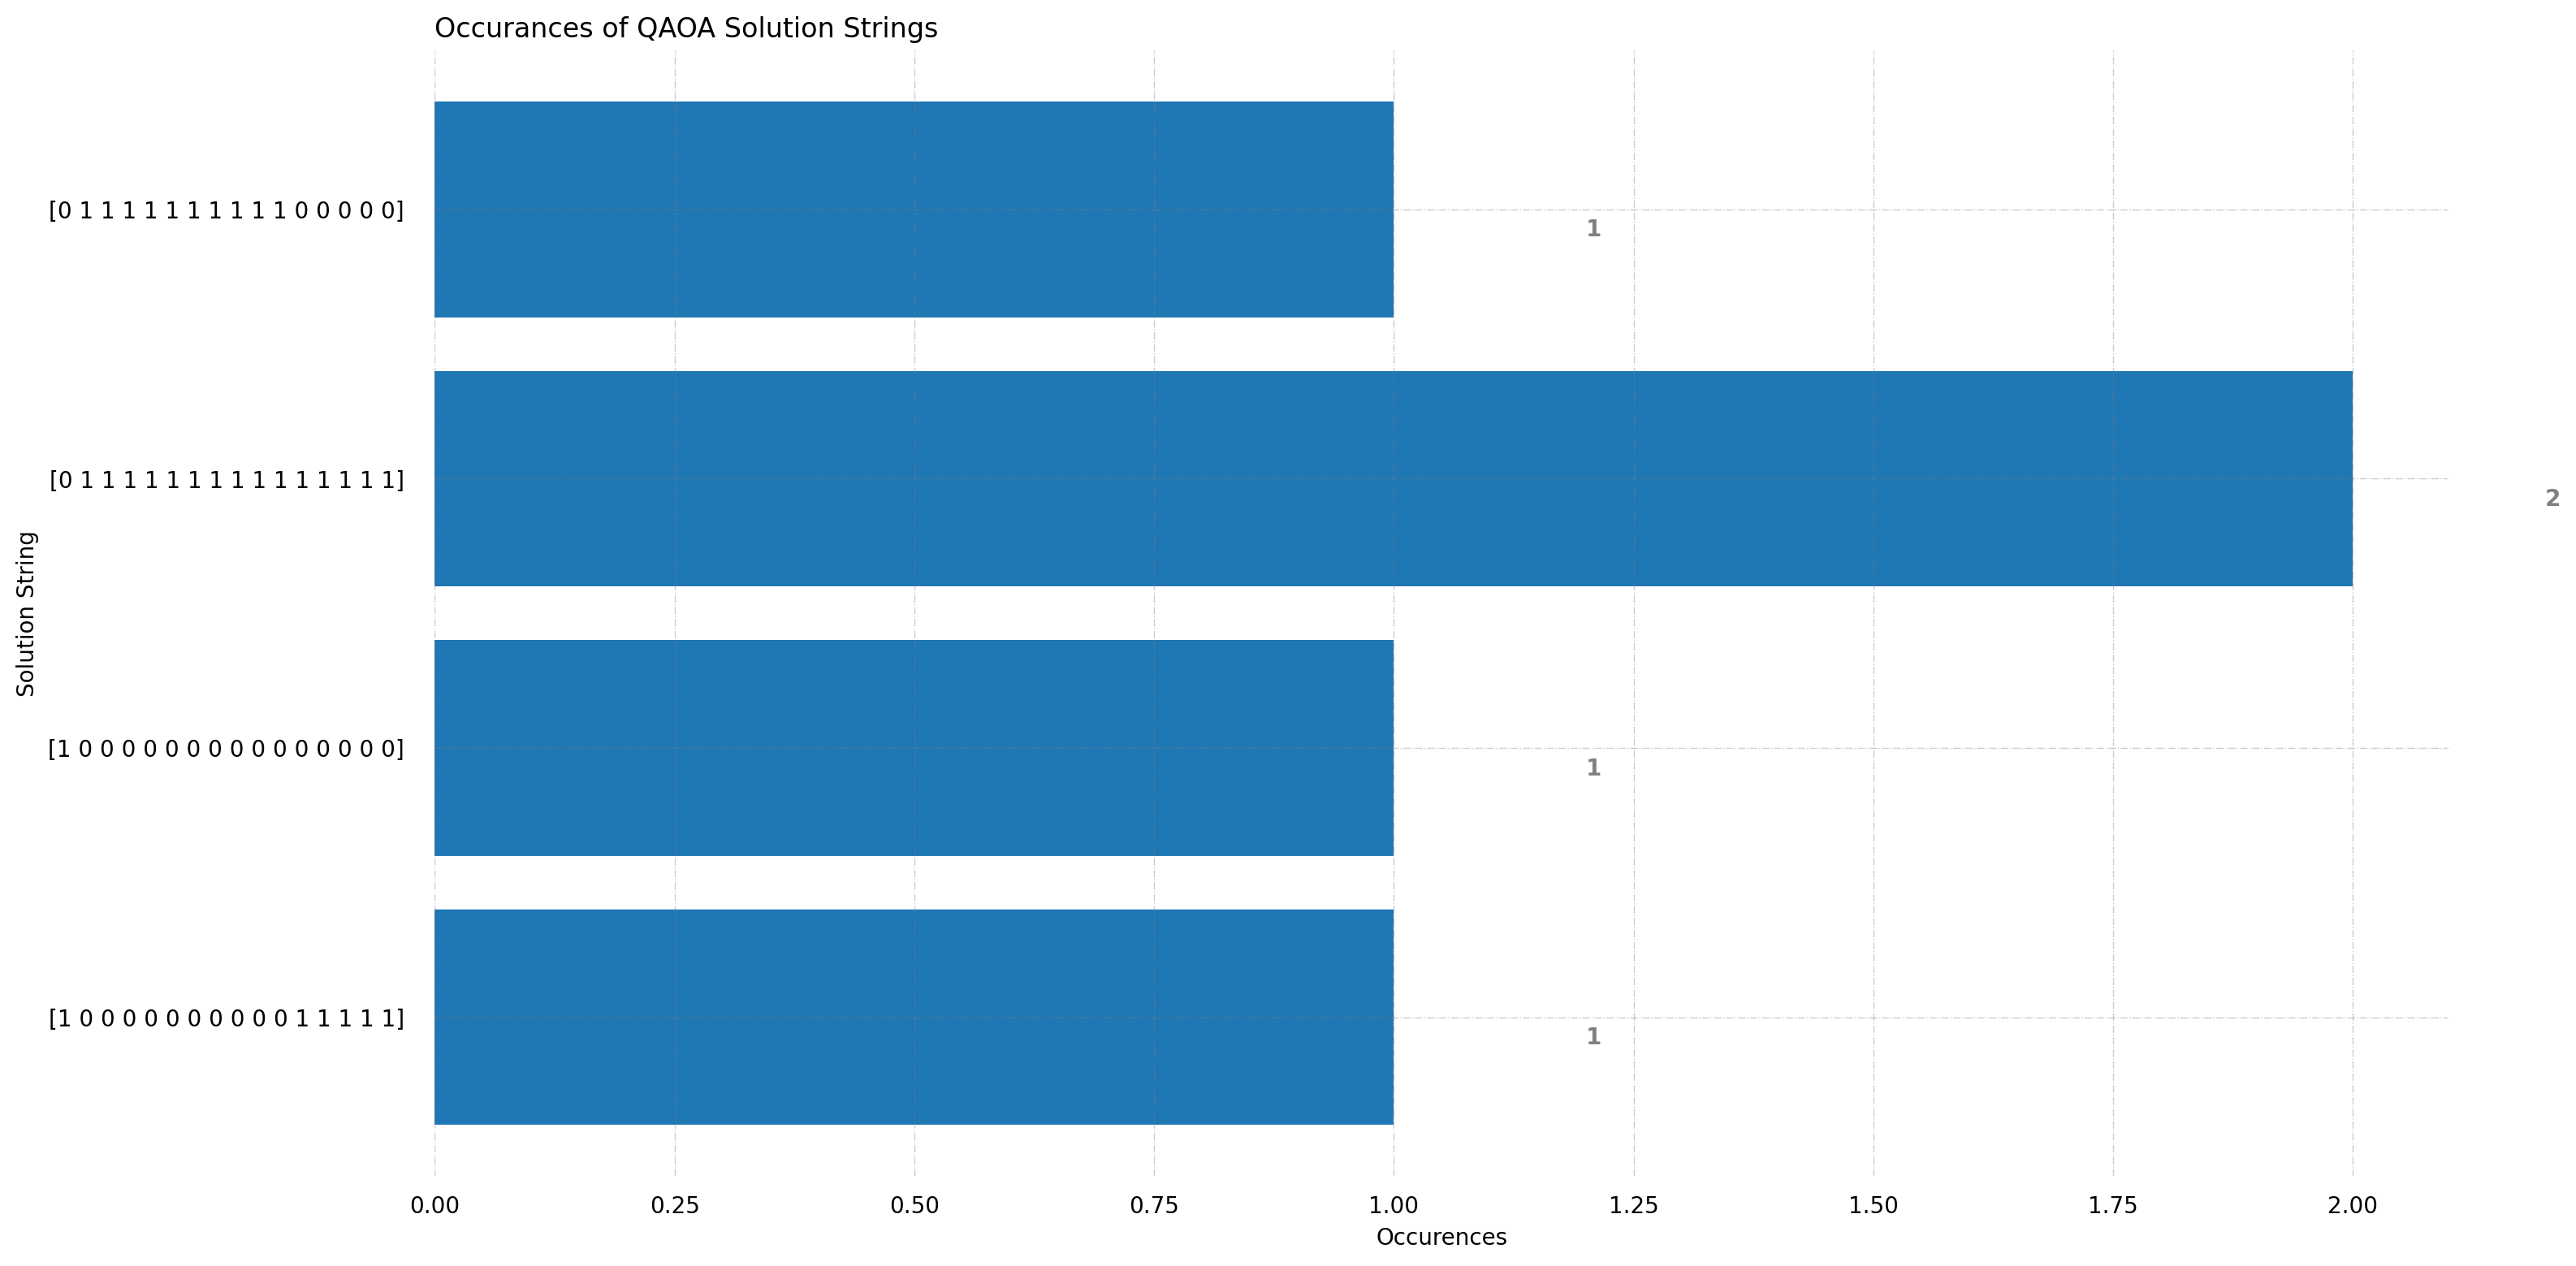

In [ ]:

labels, counts = np.unique(QAOAResultArray, return_counts=True)

ticks = range(len(counts))
# plt.bar(ticks, counts, align='center')
# plt.xticks(ticks, labels)

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

ax.barh(labels, counts)

plt.ylabel("Solution String")
plt.xlabel("Occurences")
# Add Plot Title
ax.set_title('Occurances of QAOA Solution Strings',
             loc='left', )

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.4)

# Add Text watermark
# fig.text(0.9, 0.15, '@EvanSpillane', fontsize=12, color='grey', ha='right', va='bottom', alpha=0.7)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.show()

fig.savefig(dir + "/QAOASolutionString") #save QAOA solution frequency to results


In [ ]:
#from collections import Counter

#freqListQKey = list(Counter(QAOAResultArray).keys()) # equals to list(set(words))
#freqListQ = list(Counter(QAOAResultArray).values()) # counts the elements' frequency

#avgTimePerTest = callback_dict_Q["_total_timeQ"] / testAttempts
#avgItersQ = callback_dict_Q["itersQ"] / testAttempts

#print("Results Summary")
#print("\n ===========================")

#temp = 0
#for k in freqListQKey:
  #print('Occurences of ', k ,': ', freqListQ[temp])
  #temp += 1


# print("\nTotal Iterations: ", callback_dict_Q["itersQ"])
# print("\nTotal Time: ", callback_dict_Q["_total_timeQ"])
#print("\nAverage Est. Time per test: ", str(round(avgTimePerTest, 2)),' seconds')
#print('Average Iterations per test: ', avgItersQ)


<h1> VQE Runtime Session

In [ ]:
vAnsatz = TwoLocal(qubitOp.num_qubits, "ry", "cz",
              reps=vReps, entanglement="linear")

hamiltonian = qubitOp


num_params = vAnsatz.num_parameters


In [ ]:
VQEResultList = []

callback_dict_V = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,
}


# Run SamplingVQE in a runtime session
with Session(service=service, backend=backend) as session:
    estimator = Estimator(options={"shots": 8192,
                               "resilience_level": 2,
                               "optimization_level": 3
                               # "seed_simulator": 42
                               })
    sampler = Sampler(options={"shots": 8192,
                               "resilience_level": 1,
                               "optimization_level": 3
                               # "seed_simulator": 42
                               })
    
    callbackV = buildCallback(ansatz=vAnsatz, hamiltonian=qubitOp, estimator=estimator, callback_dict=callback_dict_V, maxiter=maxiterVQE, testAttempts=testAttempts)
    optimizer = SPSA(maxiter=maxiterVQE, callback=callbackV)
    
    testNumV = 1
    for i in range(testAttempts):
        # Selecting a random starting point
        x0v = 2 * np.pi * np.random.random(num_params)
        
        # Get the result of the minimizer
        vRes = optimizer.minimize(get_cost_func(vAnsatz, qubitOp, estimator), x0v)
        
        # Assign solution parameters to ansatz
        Vqc = vAnsatz.assign_parameters(vRes.x)
        # Add measurements to our circuit
        Vqc.measure_all()
        # Sample ansatz at optimal parameters
        samp_distV = sampler.run(Vqc, shots=int(1e4)).result().quasi_dists[0]

        xVQE = max_cut.sample_most_likely(samp_distV)
        VQEResultList.append(str(xVQE))

        # testNumV = testNumV + 1

    session.close()


xVQE = max_cut.sample_most_likely(samp_distV)

colors3 = ['r' if xVQE[i] == 0 else 'c' for i in range(n)]
style3 = ['solid' if xVQE[i] == 0 else 'dashed' for i in range(n)]

print('\nAll Solutions: ')

#Adds VQE strings to results and closes text file
f = open(dir + "/Results.txt", 'w+')
toWrite += "\n\nVQE Results:\n"
for x in VQEResultList:
    print(x)
    toWrite += str(x)
f.write(toWrite)
f.close()

title3 = 'VQE Solution' + sTitle
draw_graph3(G3, colors3, pos3, title3)

plt.savefig(dir + "/BestVQE.png") #Adds VQE graph to results

KeyboardInterrupt: 

In [ ]:
from collections import Counter

avgItersVQE = callback_dict_V["iters"] / testAttempts

freqListVKey = list(Counter(VQEResultList).keys()
                    )  # equals to list(set(words))
# counts the elements' frequency
freqListV = list(Counter(VQEResultList).values())

avgTimePerTestV = callback_dict_V["_total_time"]/testAttempts


temp = 0
for k in freqListVKey:
  print('Occurences of ', k, ': ', freqListV[temp])
  temp += 1
  

#print("\nTotal Iterations: ", callback_dict["iters"])
#print('Average Iterations per test: ', avgItersVQE)

print("\nTotal Time: ", callback_dict_V["_total_time"])
print("\nAverage Est. Time per test: ", str(round(avgTimePerTestV, 2)), ' seconds')



Occurences of  [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1] :  1
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] :  1
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0] :  6
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] :  12
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1] :  5
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1] :  1
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0] :  5
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] :  5
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1] :  2
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1] :  1
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0] :  1
Occurences of  [1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0] :  1
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0] :  2
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0] :  1
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0] :  1
Occurences of  [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1] :  1
Occurences of  [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1] :  1
Occurences of  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1] :  2
Occurences of  [1 0 0 0 0 0

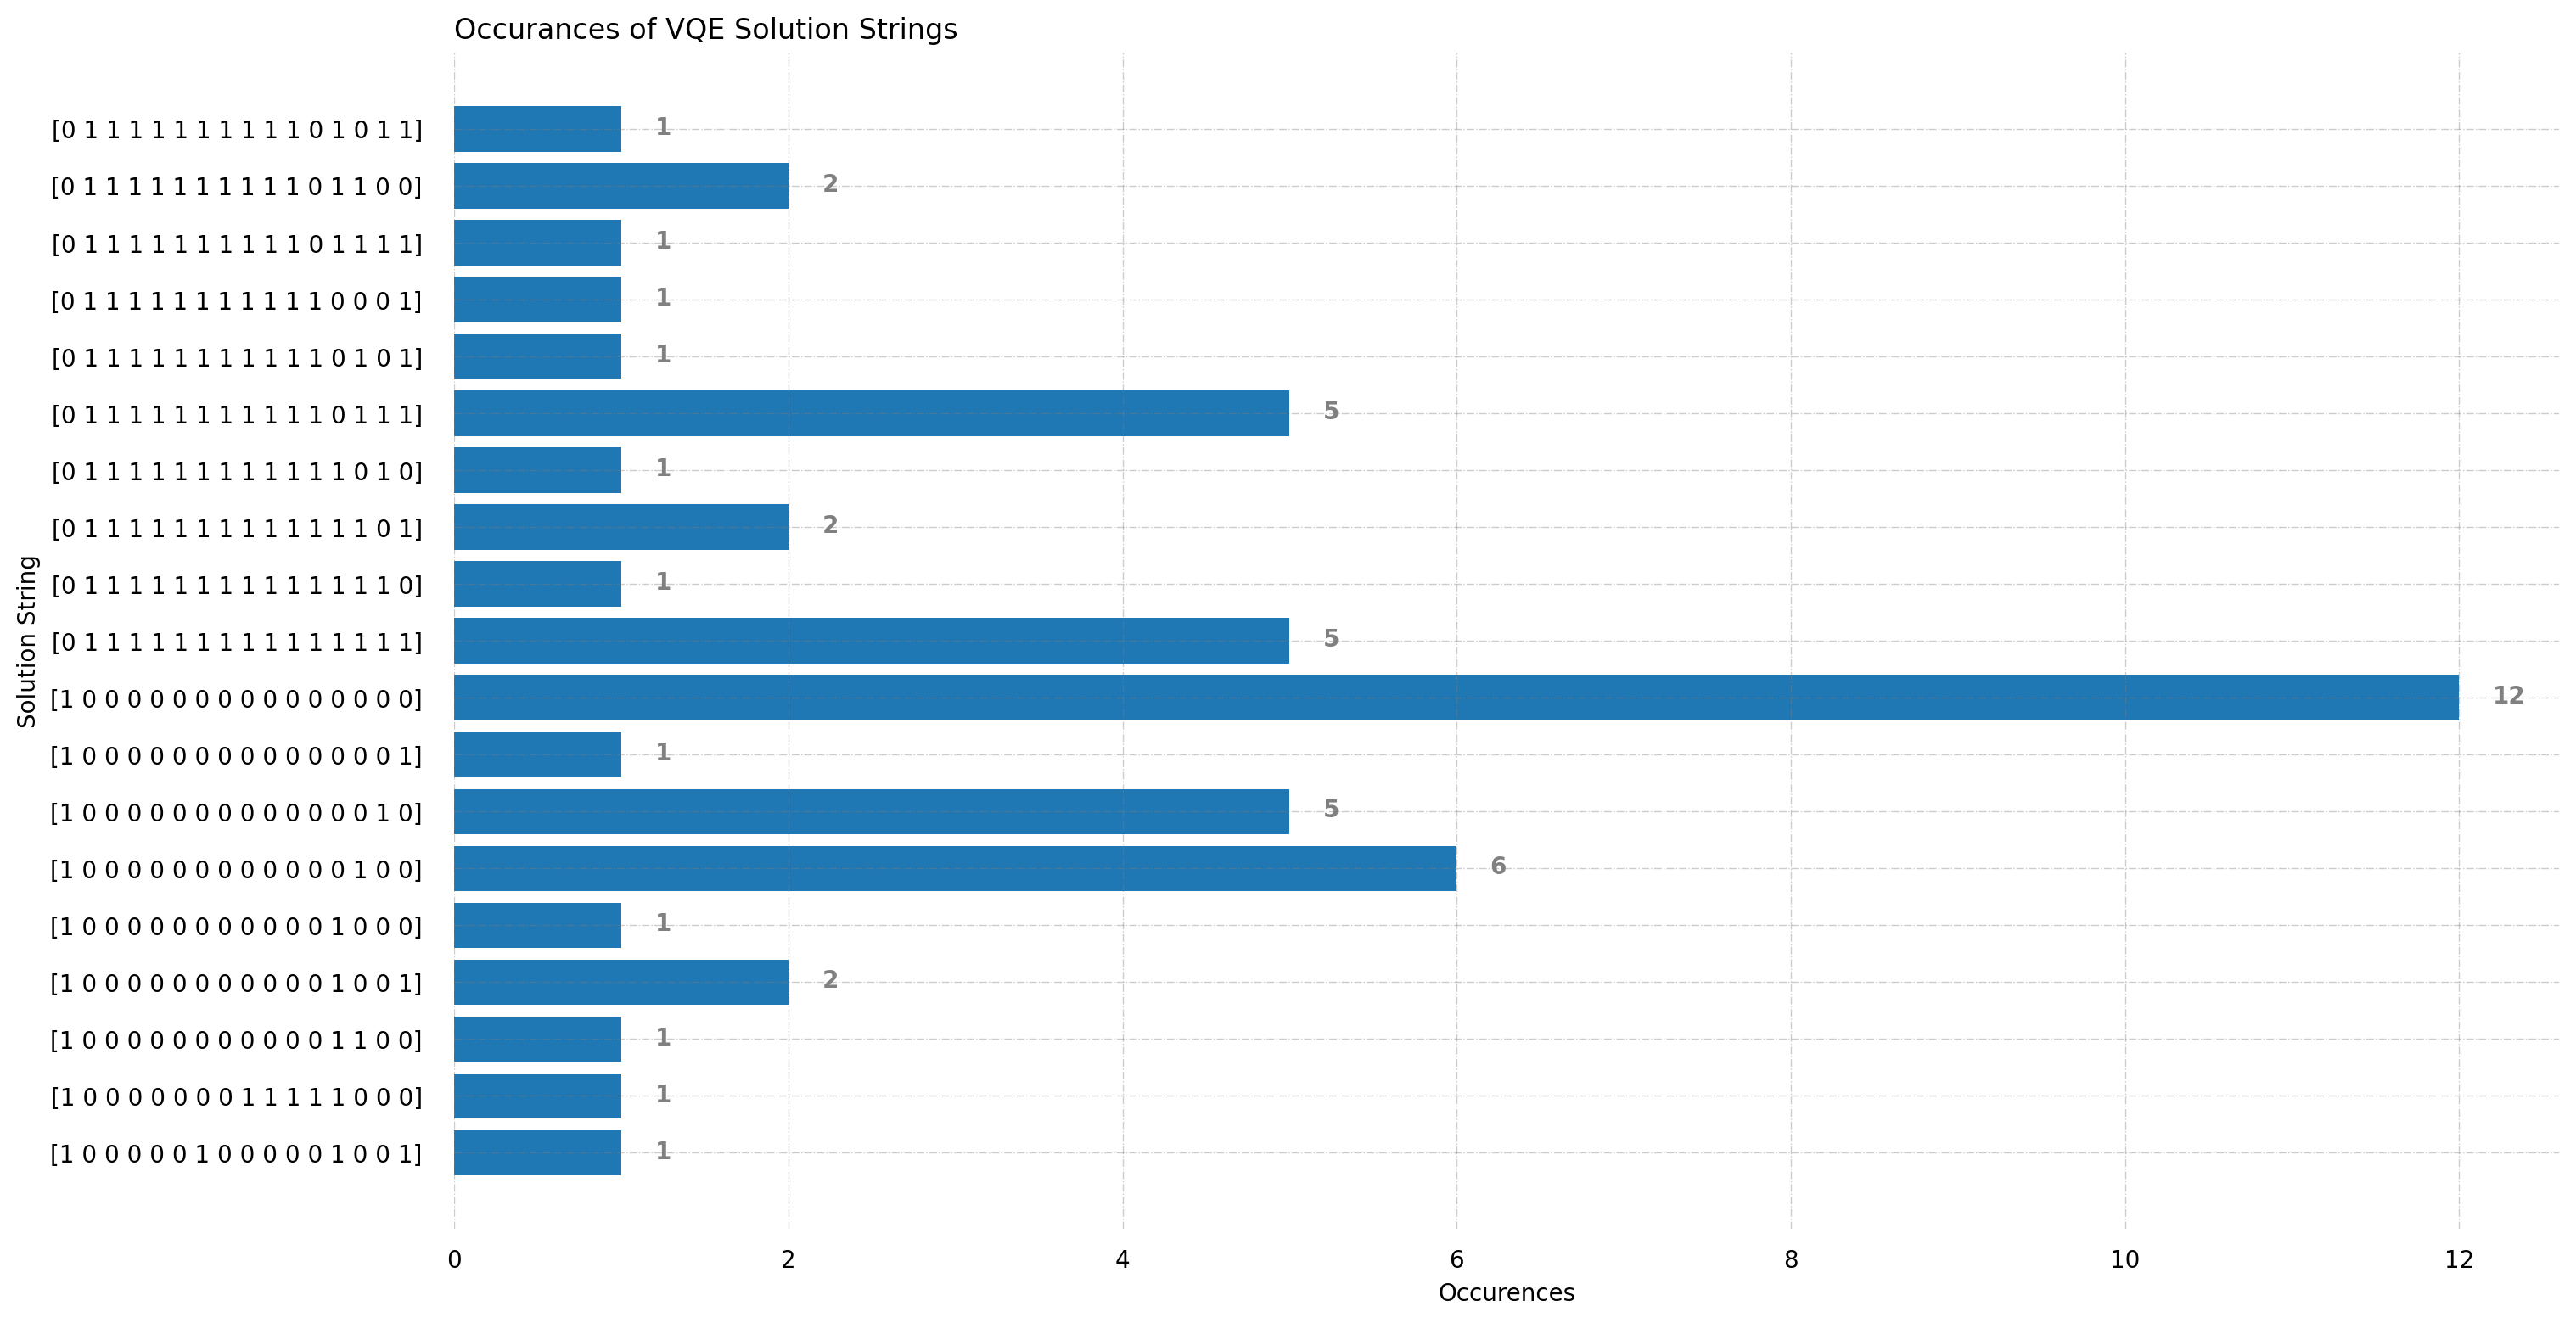

In [ ]:

labels, counts = np.unique(VQEResultList, return_counts=True)

ticks = range(len(counts))
# plt.bar(ticks, counts, align='center')
# plt.xticks(ticks, labels)

# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))

ax.barh(labels, counts)

plt.ylabel("Solution String")
plt.xlabel("Occurences")
# Add Plot Title
ax.set_title('Occurances of VQE Solution Strings',
              loc='left', )

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

# Add x, y gridlines
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.4)

# Add Text watermark
# fig.text(0.9, 0.15, '@EvanSpillane', fontsize=12, color='grey', ha='right', va='bottom', alpha=0.7)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

plt.show()

fig.savefig(dir + "/VQESolutionString") #Adds VQE solution string to results


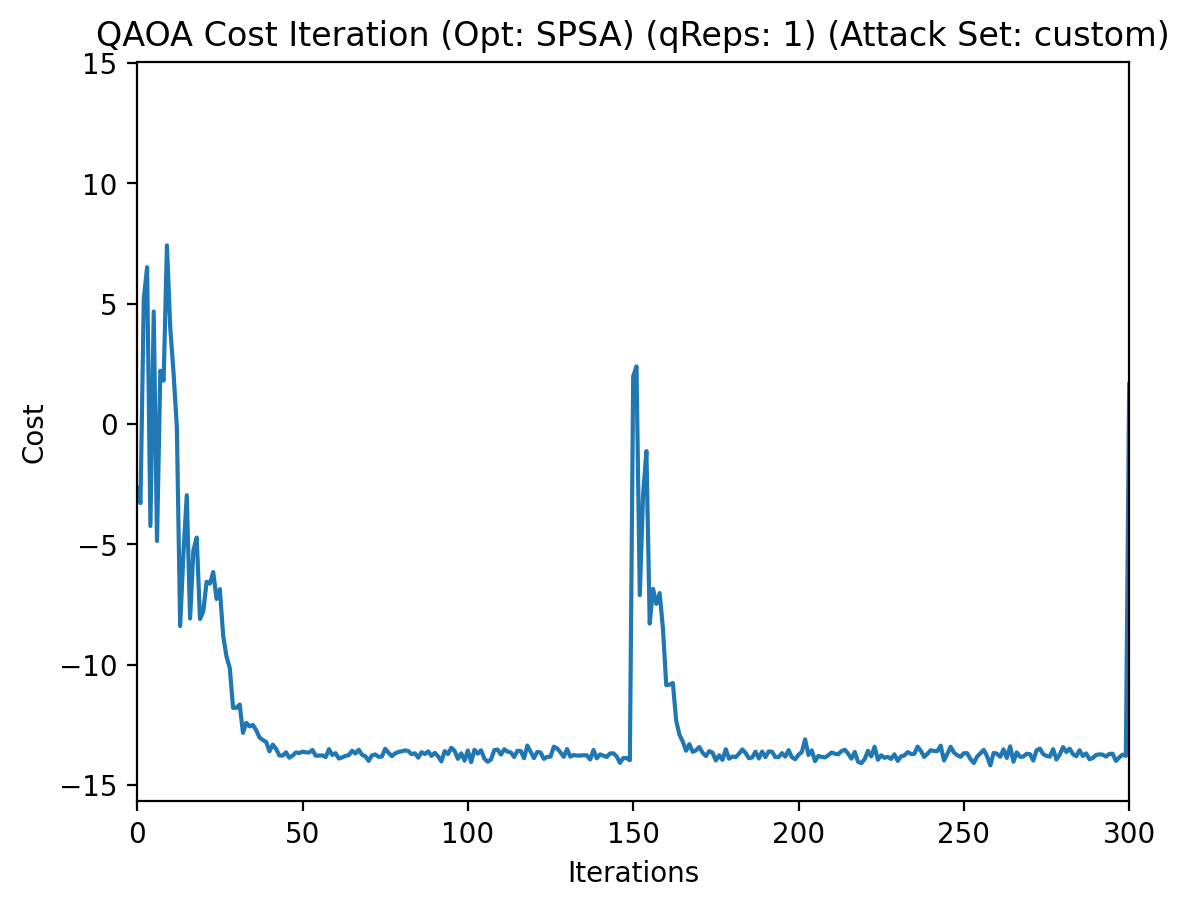

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict_Q["iters"]), callback_dict_Q["cost_history"])
avgItersQ = callback_dict_Q["iters"] / testAttempts


qxlim = maxiterQAOA*2
ax.set_xlim([0, qxlim])
plot_title = 'QAOA Cost Iteration (Opt: SPSA) (qReps: ' + str(qReps) + ') (Attack Set: ' + str(attackSet) + ')'
plt.title(plot_title)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

fig.savefig(dir + "/QAOACost2") #Adds other QAOA cost Iteratopn to results

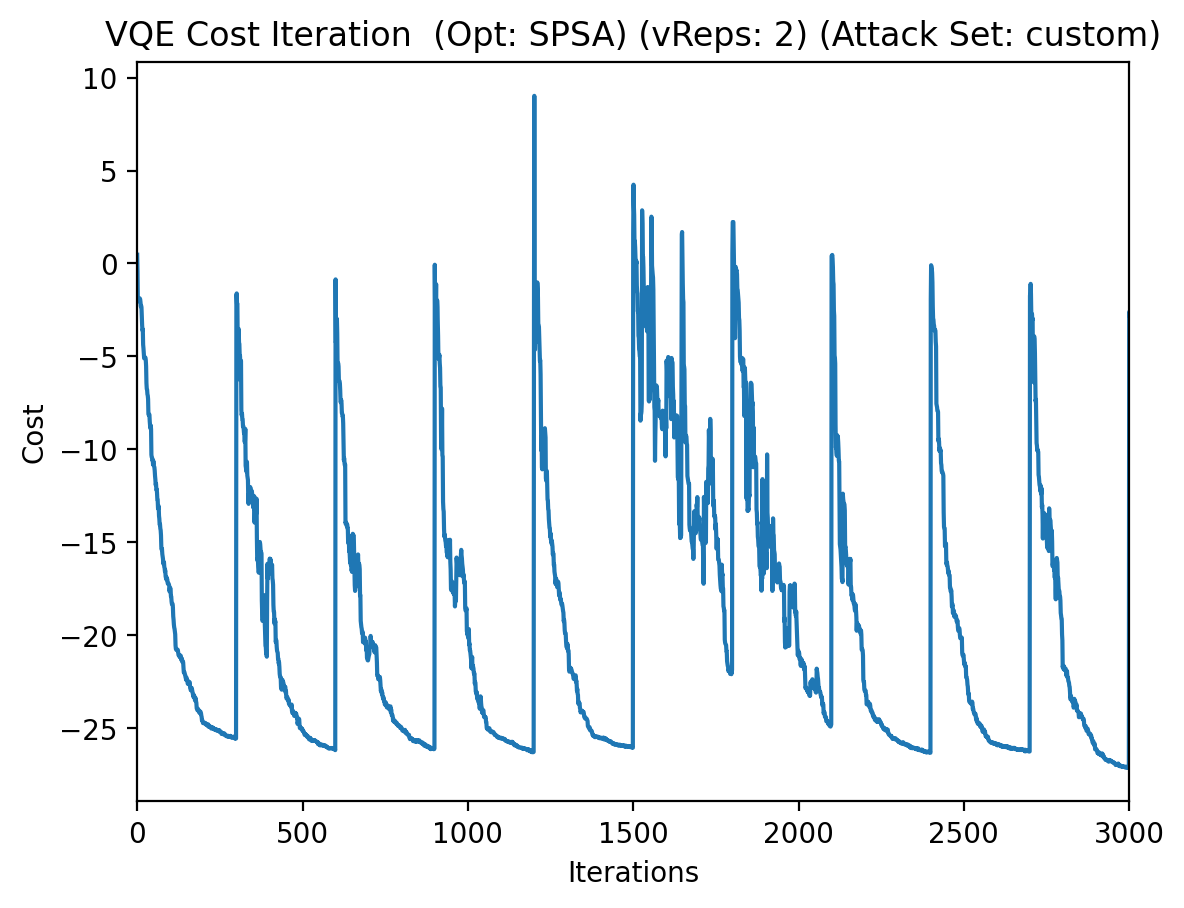

In [ ]:

fig, ax = plt.subplots()
avgItersVQE = callback_dict_V["iters"] / testAttempts

ax.plot(range(callback_dict_V["iters"]), callback_dict_V["cost_history"])
vxlim = avgItersVQE*10
#vxlim = 400
ax.set_xlim([0, vxlim])
plot_title = 'VQE Cost Iteration  (Opt: SPSA) (vReps: ' + str(vReps) + ') (Attack Set: ' +  str(attackSet) + ')'
plt.title(plot_title)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

fig.savefig(dir + "/VQECost") #Adds VQE cost iteration to results

#### End of File : )